In [1]:
import numpy as np
import h5py
%matplotlib inline
from IPython.display import Image

%load_ext autoreload
%autoreload 2

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize': 'x-large',
         'xtick.labelsize': 'large',
         'ytick.labelsize': 'large'}
pylab.rcParams.update(params)

from astropy.io import fits
from astropy.visualization import make_lupton_rgb

# Load in full dataset

In [2]:
tag = 'gri'
base_dir = '/scratch/ksf293/kavli/anomaly'
imarr_fn = f'{base_dir}/data/images_h5/images_{tag}.h5'
results_fn = f'{base_dir}/results/results_{tag}.h5'
imdict_fn = f'{base_dir}/data/idxdicts_h5/idx2imloc_{tag}.npy'
resdict_fn = f'{base_dir}/data/idxdicts_h5/idx2resloc_{tag}.npy'

In [3]:
plot_dir = '../papers/paper_neurips/images'
#plot_dir = '../plots/plots_2020-11-27' #intermediate plot dir!

In [4]:
imarr = h5py.File(imarr_fn, 'r')
res = h5py.File(results_fn, 'r')
print(imarr.keys())
print(res.keys())
print(len(imarr['idxs']))

<KeysViewHDF5 ['idxs', 'images', 'object_ids']>
<KeysViewHDF5 ['anomaly_scores', 'anomaly_scores_norm', 'anomaly_scores_rank', 'disc_scores', 'disc_scores_norm', 'disc_scores_rank', 'gen_scores', 'gen_scores_norm', 'gen_scores_rank', 'idxs', 'object_ids', 'reconstructed']>
942782


In [5]:
idx2imloc = np.load(imdict_fn, allow_pickle=True).item()
idx2resloc = np.load(resdict_fn, allow_pickle=True).item()

# Analysis & plotting routines

In [6]:
def luptonize(x, rgb_q=15, rgb_stretch=0.5, rgb_min=0):
    if x.ndim==3:
        x = make_lupton_rgb(x[:,:,2], x[:,:,1], x[:,:,0],
                      Q=rgb_q, stretch=rgb_stretch, minimum=rgb_min)
    elif x.ndim==4:
        x = np.array([make_lupton_rgb(xi[:,:,2], xi[:,:,1], xi[:,:,0],
                      Q=rgb_q, stretch=rgb_stretch, minimum=rgb_min)
                      for xi in x])
    else:
        raise ValueError(f"Wrong number of dimensions! Gave {x.ndim}, need 3 or 4")
    return x

In [7]:
def get_residual(im, recon):
    im = np.array(im)
    reals = im.reshape((96,96,-1))
    #reals = luptonize(reals).astype('int')
    recon = np.array(recon)
    recon = recon.reshape((96,96,-1)).astype('int')
    resid = abs(im-recon)
    return resid

In [8]:
def plot_recons(ids, saveto=None, border_color=None):
    nims = len(ids)
    subsize = 2
    fig, axarr = plt.subplots(3,nims,figsize=(nims*subsize,3*subsize), edgecolor=border_color)
    plt.subplots_adjust(hspace=0.02, wspace=0.1)
    count = 0
    for i in range(nims):
        idx = ids[i]
        
        loc = idx2imloc[idx]
        im = luptonize(imarr['images'][loc])
        
        rloc = idx2resloc[idx]
        recon = res['reconstructed'][rloc]
        score = float(res['anomaly_scores_norm'][rloc])
        obj_id = res['object_ids'][rloc]
        resid = get_residual(im, recon)
        
        ax0 = axarr[0][i]
        ax1 = axarr[1][i]
        ax2 = axarr[2][i]
        title = r'''ID: {}
$s_\mathrm{{anom}}$ = {:.4f}'''.format(obj_id, score)
        ax0.set_title(title, fontsize=8)
        ax0.imshow(im)
        ax1.imshow(recon)
        ax2.imshow(resid)
        
        if i==0:
            fsize=13
            ax0.set_ylabel("real",fontsize=fsize)
            ax1.set_ylabel("reconstructed",fontsize=fsize)
            ax2.set_ylabel("residual",fontsize=fsize)
        
        for ax in [ax0, ax1, ax2]:
            ax.set_xticks([])
            ax.set_yticks([])
    
    if border_color is not None:
        fig.patch.set_edgecolor(border_color)  
        fig.patch.set_linewidth('4') 
        
    if saveto:
        plt.savefig(saveto, bbox_inches='tight', edgecolor=border_color)#, pad_inches=0)

In [9]:
def get_anomalies(scores, idxs, sigma_min, sigma_max, n=4, seed=17):
    np.random.seed(seed)
    scores = np.array(scores)
    mean = np.mean(scores)
    std = np.std(scores)
    amin = mean+sigma_min*std
    amax = mean+sigma_max*std
    aindices = np.where((scores >= amin) & (scores < amax))[0]
    aindices_n = np.random.choice(aindices, n)
    return np.array(idxs)[aindices_n]

# Figure 1: reconstructions of diff anomaly scores

In [10]:
scores = res['anomaly_scores']
ridxs = res['idxs']

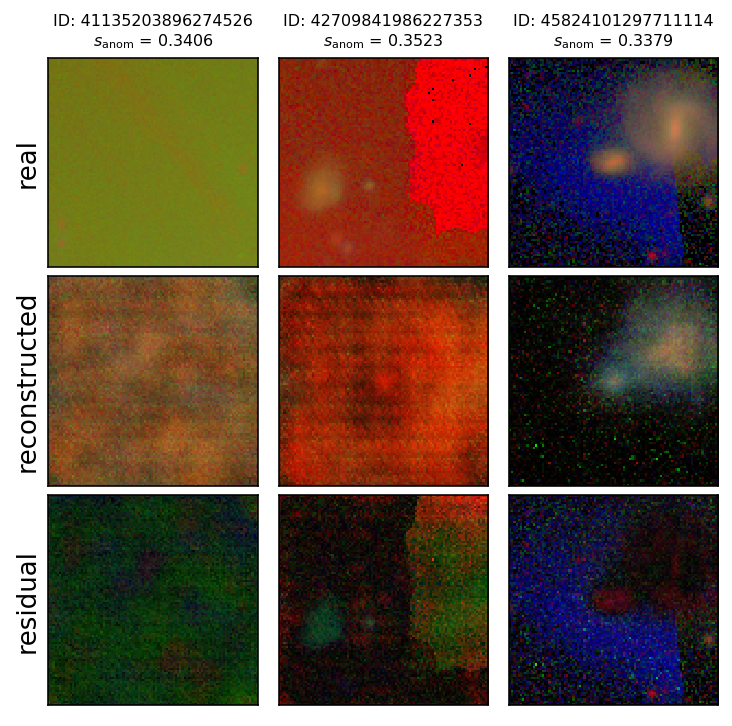

In [11]:
ids_59sig = get_anomalies(scores, ridxs, 5, 9, n=3, seed=23) #15,19 good
plot_recons(ids_59sig, saveto=f'{plot_dir}/recons_5-9sig.png')

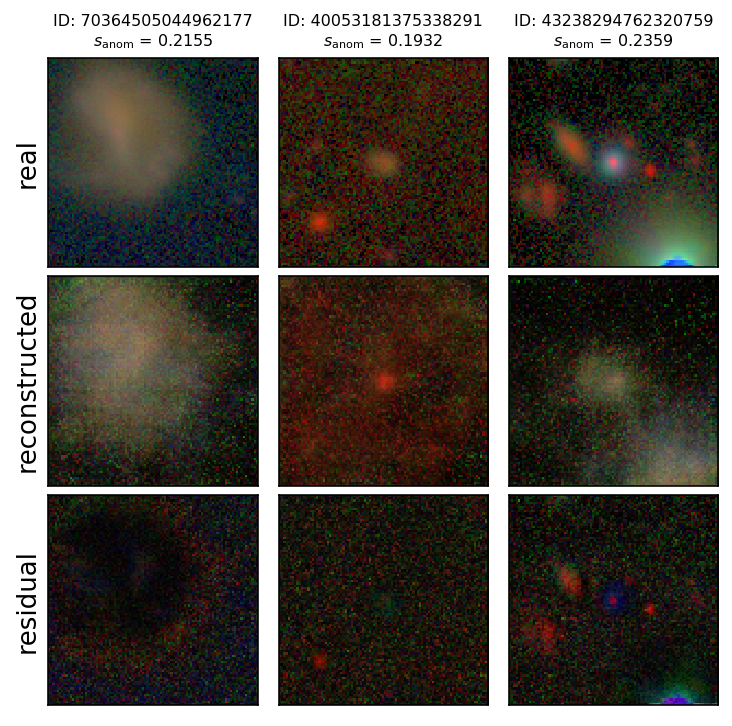

In [12]:
ids_59sig = get_anomalies(scores, ridxs, 2, 4, n=3, seed=19) #14, 11,3 best so far = #8 has a nice gal!!
plot_recons(ids_59sig, saveto=f'{plot_dir}/recons_2-4sig.png')

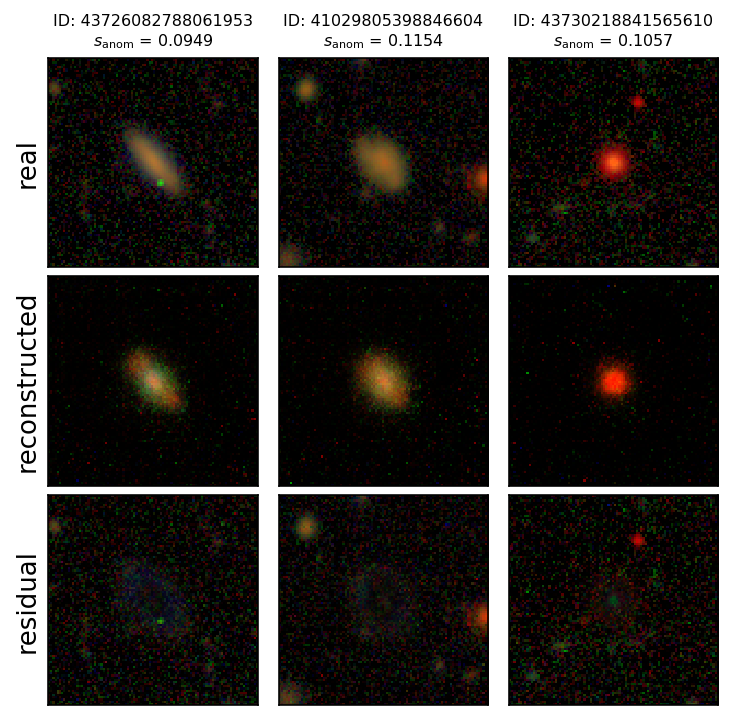

In [13]:
ids_59sig = get_anomalies(scores, ridxs, -3, -1, n=3, seed=15)
plot_recons(ids_59sig, saveto=f'{plot_dir}/recons_n3-n1sig.png')

## UMAPS

In [14]:
def plot_umap(embedding, saveto=None, highlight_arrs=None, highlight_colors=None, 
              highlight_markers=None, cmap='plasma_r', boxes=None, box_colors=None, 
              figsize=(8,7), colorby=None, vmin=None, alpha=0.2, s=6):
    e1, e2, cby, idxs = embedding
    if colorby is None:
        colorby = cby

    if vmin is None:
        vmin = min(colorby)
    vmax = 0.35*max(colorby)
    
    plt.figure(figsize=figsize)
    plt.scatter(e1, e2, marker='.', c=colorby, cmap=cmap, s=s, vmin=vmin, vmax=vmax, alpha=alpha)
    
    if highlight_arrs is not None:
        if np.array(highlight_arrs).ndim==1:
            highlight_arrs = [highlight_arrs]
        for i, highlight_ids in enumerate(highlight_arrs):
            argidxs = [np.where(idxs==hi)[0][0] for hi in highlight_ids]
            plt.scatter(e1[argidxs], e2[argidxs], marker=highlight_markers[i], c=colorby[argidxs], 
                            edgecolor=highlight_colors[i], lw=2, 
                            cmap=cmap, s=270, vmin=vmin, vmax=vmax)
            
    if boxes is not None:
        for i, box in enumerate(boxes):
            amin, amax, bmin, bmax = boxes[i]
            width = amax - amin
            height = bmax - bmin
            rect = matplotlib.patches.Rectangle((amin,bmin),width,height,linewidth=2,
                                                edgecolor=box_colors[i],facecolor='none')
            ax = plt.gca()
            ax.add_patch(rect)
        
    plt.xlabel('umap A')
    plt.ylabel('umap B')

    cbar = plt.colorbar(extend='max')
    cbar.set_label(r'$s_\mathrm{anom}$, anomaly score', rotation=270, labelpad=18)
    cbar.set_alpha(1)
    cbar.draw_all()
    
    plt.gca().set_aspect('equal', 'datalim')
    
    if saveto:
        plt.savefig(saveto, bbox_inches='tight')

### 100k

In [15]:
embed_dir = "/scratch/ksf293/kavli/anomaly/results/embeddings"
taga = 'gri_100k'
umap_tag = '_nn5md0.1'
auto_tag = '_model29500_latent16'

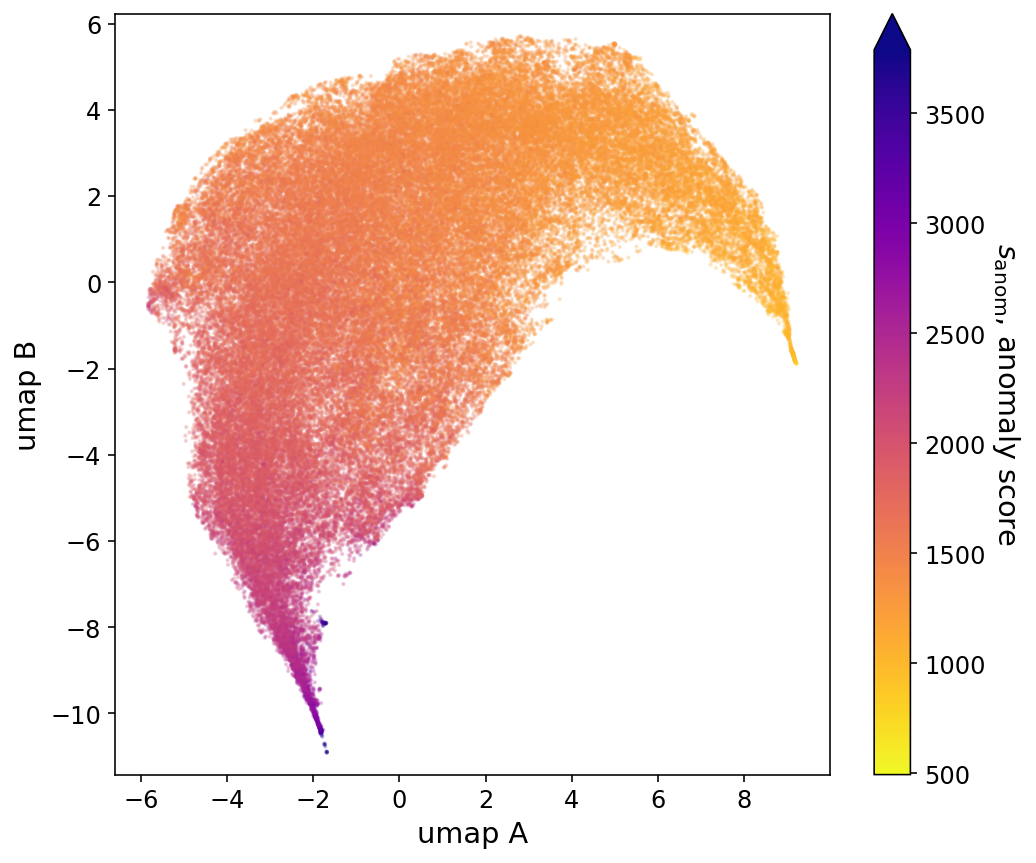

In [16]:
embedding = np.load(f"{embed_dir}/embedding_umap_auto_{taga}{auto_tag}{umap_tag}.npy", allow_pickle=True)
plot_umap(embedding, saveto=f'{plot_dir}/umap_100k_resids_auto.png')

### 3sig with shapes

In [17]:
def get_highlights(highlight_arrs, colors, markers):
    assert len(highlight_arrs)==len(colors) and len(colors)==len(markers), "arrays must be same length!"
    highlight_ids = np.concatenate(highlight_arrs)
    highlight_colors = [[colors[c]]*len(highlight_arrs[c]) for c in range(len(colors))]
    highlight_colors = np.concatenate(highlight_colors)
    highlight_markers = [[markers[m]]*len(highlight_arrs[m]) for m in range(len(markers))]
    highlight_markers = np.concatenate(highlight_markers)
    return highlight_ids, highlight_colors, highlight_markers

In [18]:
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('Purples')
cmap_purp = truncate_colormap(cmap, 0.25, 1.0)

In [19]:
embed_dir = "/scratch/ksf293/kavli/anomaly/results/embeddings"
taga = 'gri_3sig'
umap_tag = '_nn5md0.1'
auto_tag = '_model29500_latent32'

In [20]:
extended_purple = [105685, 80217, 539520]#, 378977, 43986, 355424]
mergers_upper = [157767,147100,105162]
blue_sf = [461525, 86279,707620]#,782291]

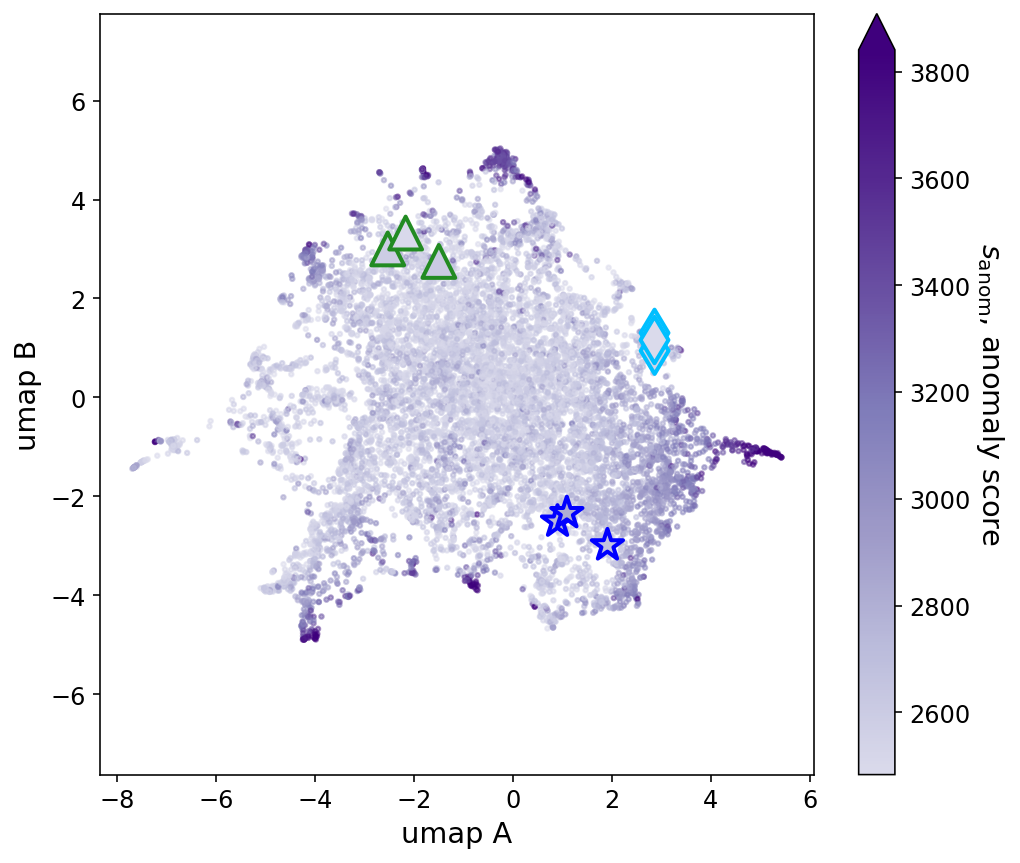

In [21]:
embedding = np.load(f"{embed_dir}/embedding_umap_auto_{taga}{auto_tag}{umap_tag}.npy", allow_pickle=True)
highlight_arrs = [mergers_upper, extended_purple, blue_sf]
highlight_colors = ['forestgreen', 'deepskyblue', 'blue']
highlight_markers = ['^', 'd', '*']
saveto = f'{plot_dir}/umap_3sig_resids_auto_highlight.png'
plot_umap(embedding, highlight_arrs=highlight_arrs, highlight_colors=highlight_colors, 
          highlight_markers=highlight_markers, saveto=saveto, cmap=cmap_purp, alpha=0.5, s=20)

### Figure 2 panels c-e, clustered interesting anomalies with reconstructions & resids

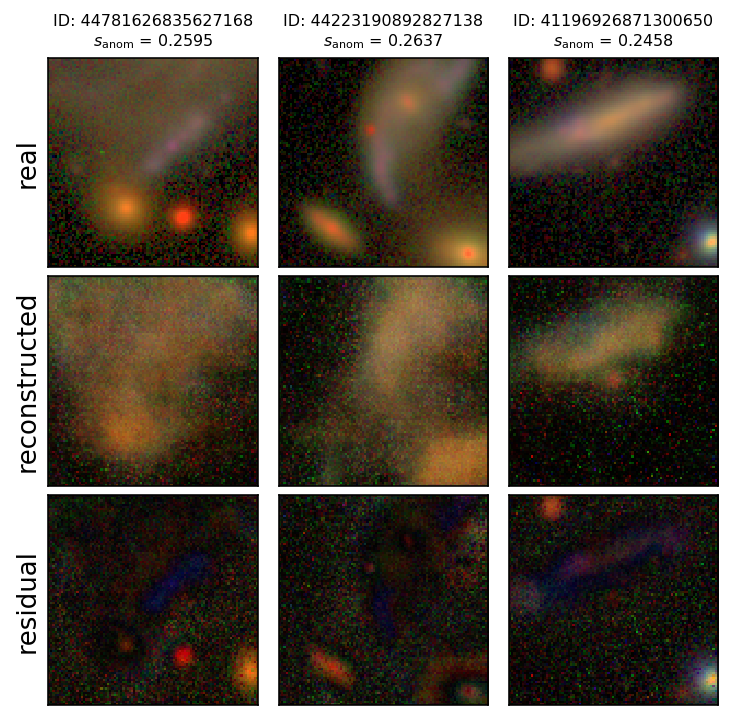

In [22]:
saveto = f'{plot_dir}/cluster_recon_extendedpurple.png'
plot_recons(extended_purple,saveto=saveto)

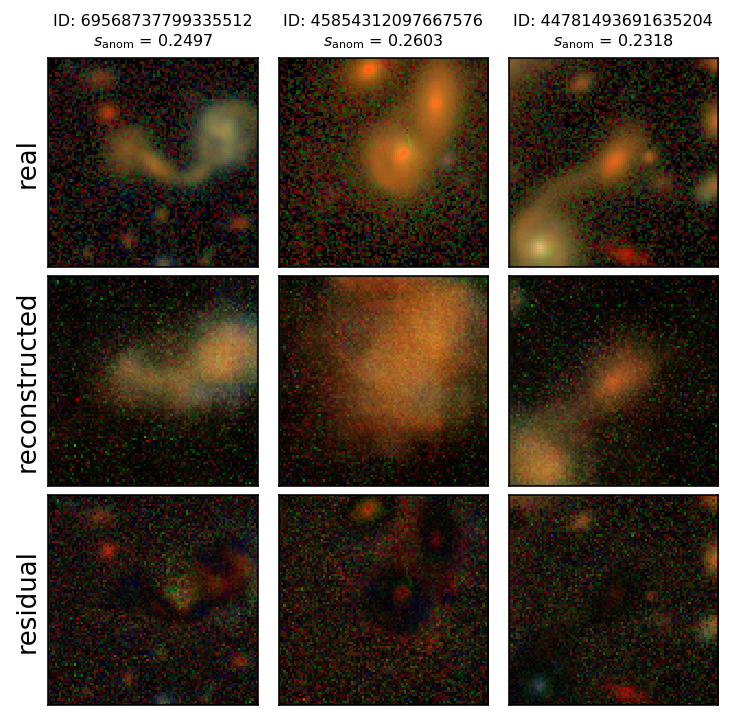

In [23]:
saveto = f'{plot_dir}/cluster_recon_mergers.png'
plot_recons(mergers_upper,saveto=saveto)

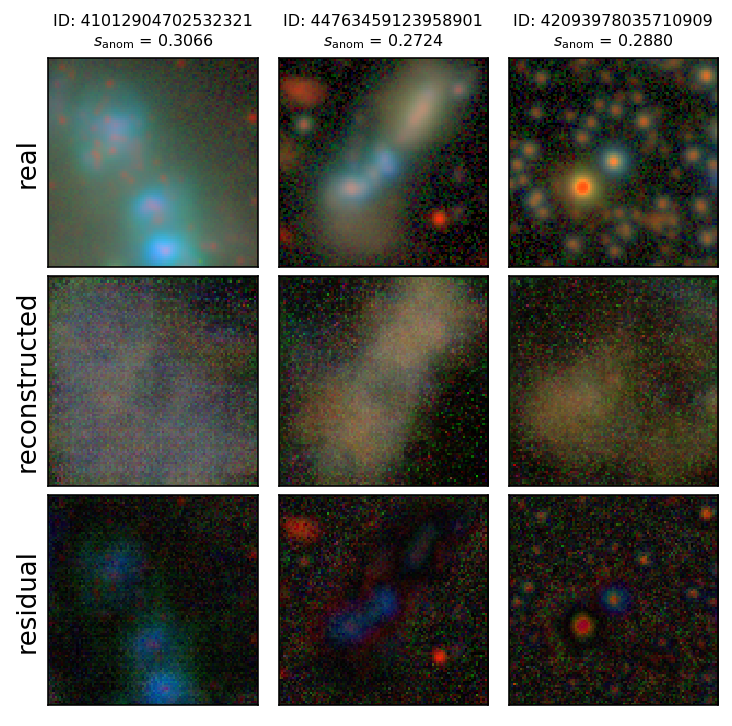

In [24]:
saveto = f'{plot_dir}/cluster_recon_bluesf.png'
plot_recons(blue_sf,saveto=saveto)